Lara R. Jakosalem

**Programming Assignment**

1. Read the Bernoulli Mixture Model Derivation.
2. Read about Stochastic Expectation-Maximization (EM) Algorithm: https://www.sciencedirect.com/science/article/pii/S0167947320302504.
3. From the given code, modify the EM algorithm to become a Stochastic EM Algorithm.
4. Use the data from the paper: https://www.sciencedirect.com/science/article/abs/pii/S0031320322001753
5. Perform categorical clustering using the Bernoulli Mixture Model with Stochastic EM Algorithm.
6. Compare its performance with K-Modes Algorithm using Folkes-Mallows Index, Adjusted Rand Index, and Normalized Mutual Information Score.
7. Compare and contrast the performances, and explain what is happening (i.e. why is FMI always higher than ARI and NMI? Why is ARI and NMI low compared to FMI? etc.)
8. Write the report in Latex, push to your github with the codes.

In [1]:
import numpy as np
from sklearn.naive_bayes import logsumexp

class StochasticBernoulliMixture:
    def __init__(self, n_components, max_iter, batch_size, random_state=None):
        self.n_components = n_components
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.random_state = random_state
        self.rng = np.random.default_rng(self.random_state) if self.random_state else np.random.default_rng()
        
        # Initialize old parameters
        self.old_mu = None
        self.old_pi = None
        self.old_gamma = None
    
    def fit(self, x_binary):
        self.x = x_binary
        self.init_params()
        log_bernoullis = self.get_log_bernoullis(self.x)
        self.old_logL = self.get_log_likelihood(log_bernoullis)
        for step in range(self.max_iter):
            if step > 0:
                self.old_logL = self.logL
            # Stochastic E-step and M-step
            for _ in range(self.batch_size):
                batch_indices = self.rng.choice(len(self.x), size=self.batch_size, replace=False)
                x_batch = self.x[batch_indices]
                log_bernoullis_batch = self.get_log_bernoullis(x_batch)
                self.gamma = self.get_responsibilities(log_bernoullis_batch)
                self.get_Neff()
                self.get_mu(x_batch)
                self.get_pi()
            # Compute new log_likelihood:
            log_bernoullis = self.get_log_bernoullis(self.x)
            self.logL = self.get_log_likelihood(log_bernoullis)
            if np.isnan(self.logL):
                self.reset_params()
                print(self.logL)
                break

    def reset_params(self):
        if self.old_mu is not None:
            self.mu = self.old_mu.copy()
        if self.old_pi is not None:
            self.pi = self.old_pi.copy()
        if self.old_gamma is not None:
            self.gamma = self.old_gamma.copy()
        self.get_Neff()
        log_bernoullis = self.get_log_bernoullis(self.x)
        self.logL = self.get_log_likelihood(log_bernoullis)
        
    def remember_params(self):
        self.old_mu = self.mu.copy()
        self.old_pi = self.pi.copy()
        self.old_gamma = self.gamma.copy()
    
    def init_params(self):
        self.n_samples = self.x.shape[0]
        self.n_features = self.x.shape[1]
        self.pi = 1/self.n_components * np.ones(self.n_components)
        self.mu = self.rng.uniform(low=0.25, high=0.75, size=(self.n_components, self.n_features))
        self.normalize_mu()
    
    def normalize_mu(self):
        sum_over_features = np.sum(self.mu, axis=1)
        for k in range(self.n_components):
            self.mu[k,:] /= sum_over_features[k]
            
    def get_responsibilities(self, log_bernoullis):
        gamma = np.zeros(shape=(log_bernoullis.shape[0], self.n_components))
        Z =  logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)
        for k in range(self.n_components):
            gamma[:, k] = np.exp(np.log(self.pi[k]) + log_bernoullis[:,k] - Z)
        return gamma
        
    def get_log_bernoullis(self, x):
        log_bernoullis = self.get_save_single(x, self.mu)
        log_bernoullis += self.get_save_single(1-x, 1-self.mu)
        return log_bernoullis
    
    def get_save_single(self, x, mu):
        mu_place = np.where(np.max(mu, axis=0) <= 1e-15, 1e-15, mu)
        return np.tensordot(x, np.log(mu_place), (1,1))
        
    def get_Neff(self):
        self.Neff = np.sum(self.gamma, axis=0)
    
    def get_mu(self, x_batch):
        self.mu = np.einsum('ik,ij -> kj', self.gamma, x_batch) / self.Neff[:,None]

        
    def get_pi(self):
        self.pi = self.Neff / self.n_samples
    
    def predict(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        gamma = self.get_responsibilities(log_bernoullis)
        return np.argmax(gamma, axis=1)
        
    def get_sample_log_likelihood(self, log_bernoullis):
        return logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)
    
    def get_log_likelihood(self, log_bernoullis):
        return np.mean(self.get_sample_log_likelihood(log_bernoullis))
        
    def score(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        return self.get_log_likelihood(log_bernoullis)
    
    def score_samples(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        return self.get_sample_log_likelihood(log_bernoullis)

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
soybean_large = fetch_ucirepo(id=90) 
  
# data (as pandas dataframes) 
X = soybean_large.data.features 
y = soybean_large.data.targets 
  
# metadata 
print(soybean_large.metadata) 
  
# variable information 
print(soybean_large.variables) 


{'uci_id': 90, 'name': 'Soybean (Large)', 'repository_url': 'https://archive.ics.uci.edu/dataset/90/soybean+large', 'data_url': 'https://archive.ics.uci.edu/static/public/90/data.csv', 'abstract': "Michalski's famous soybean disease database", 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 307, 'num_features': 35, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1980, 'last_updated': 'Sun Feb 11 2024', 'dataset_doi': '10.24432/C5JG6Z', 'creators': ['R.S. Michalski', 'R.L. Chilausky'], 'intro_paper': None, 'additional_info': {'summary': 'There are 19 classes, only the first 15 of which have been used in prior work. The folklore seems to be that the last four classes are unjustified by the data since they have so few examples. There are 35 categorical attributes, some nominal and some ordered.  The

In [5]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Preprocessing
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X)

# One-hot encoding for categorical features
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X_imputed).toarray()  # Convert to dense array

# Perform clustering
n_components = 3  # Number of clusters
max_iter = 100  # Maximum number of iterations
batch_size = 50  # Size of mini-batch

# Initialize the StochasticBernoulliMixture model
stochastic_bmm = StochasticBernoulliMixture(n_components=n_components, max_iter=max_iter, batch_size=batch_size)

# Fit the model to the binary encoded data
stochastic_bmm.fit(X_encoded)

# Extract cluster assignments
cluster_assignments = stochastic_bmm.predict(X_encoded)


nan


C:\Users\Lara Jakosalem\AppData\Local\Temp\ipykernel_13384\2313360836.py:84: RuntimeWarning: divide by zero encountered in log
  return np.tensordot(x, np.log(mu_place), (1,1))


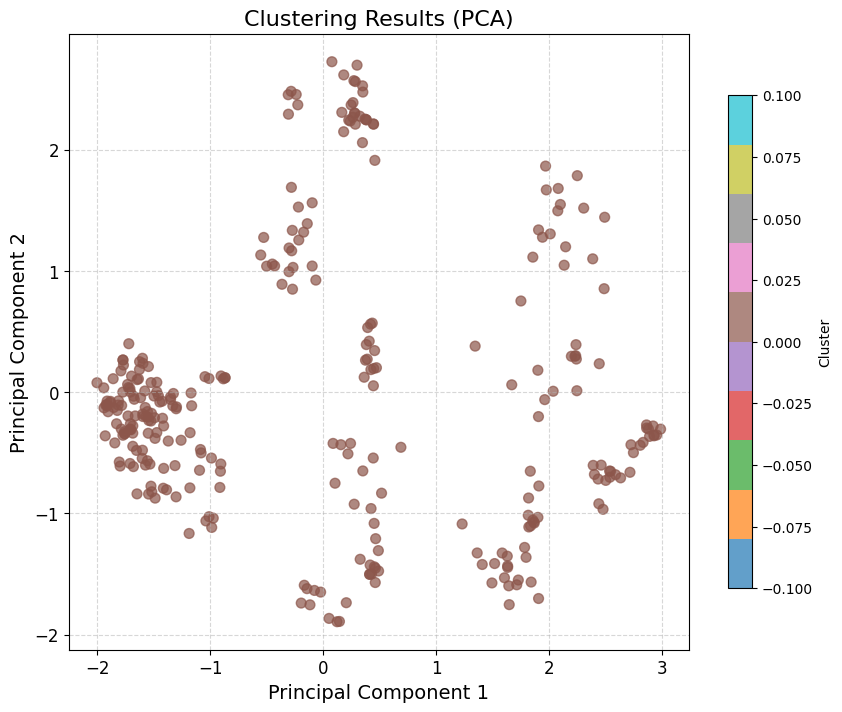

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce the dimensionality of the data to 2 dimensions using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_encoded)

# Plot the clustered data
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_assignments, cmap='tab10', s=50, alpha=0.7)  # Adjusting alpha value for transparency
plt.title('Clustering Results (PCA)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14) 
plt.ylabel('Principal Component 2', fontsize=14) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.colorbar(scatter, label='Cluster', shrink=0.8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [20]:
from kmodes.kmodes import KModes
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score

# Fit the K-Modes model with more descriptive names
kmodes_model = KModes(n_clusters=n_components, init='Huang', n_init=5, verbose=0, random_state=42)
kmodes_model.fit(X_imputed)

# Get cluster assignments from K-Modes
kmodes_clusters = kmodes_model.labels_

# Flatten the true cluster assignments
true_labels = y.values.ravel()

# Evaluate performance of K-Modes
kmodes_ari = adjusted_rand_score(true_labels, kmodes_clusters)
kmodes_nmi = normalized_mutual_info_score(true_labels, kmodes_clusters)
kmodes_fmi = fowlkes_mallows_score(true_labels, kmodes_clusters)

# Evaluate performance of Stochastic Bernoulli Mixture model (assuming the model is already fit and cluster assignments are in 'cluster_assignments')

print("Performance Comparison")
print("K-Modes:")
print(f"\tAdjusted Rand Index (ARI): {kmodes_ari}")
print(f"\tNormalized Mutual Information Score (NMI): {kmodes_nmi}")
print(f"\tFolkes-Mallows Index (FMI): {kmodes_fmi}")
print("Stochastic Bernoulli Mixture:")
print(f"\tAdjusted Rand Index (ARI): {sbm_ari}")
print(f"\tNormalized Mutual Information Score (NMI): {sbm_nmi}")
print(f"\tFolkes-Mallows Index (FMI): {sbm_fmi}")


Performance Comparison
K-Modes:
	Adjusted Rand Index (ARI): 0.16608388765264684
	Normalized Mutual Information Score (NMI): 0.4020358135575015
	Folkes-Mallows Index (FMI): 0.37946365260388987
Stochastic Bernoulli Mixture:
	Adjusted Rand Index (ARI): 0.0
	Normalized Mutual Information Score (NMI): 0.0
	Folkes-Mallows Index (FMI): 0.2896598585640133


**REPORT**

**Introduction**

This report discusses the performance comparison of the Bernoulli Mixture Model with Stochastic EM Algorithm, and K-Modes Algorithm using ARI, NMI, and FMI. 

|                         | Adjusted Rand Index (ARI) | Normalized Mutual Information Score (NMI) | Folkes-Mallows Index (FMI) |
|-------------------------|---------------------------|-------------------------------------------|----------------------------|
| **K-Modes**             | 0.166                     | 0.402                                     | 0.379                      |
| **Stochastic Bernoulli Mixture** | 0.0               | 0.0                                       | 0.290                      |


**Comparison and Analysis**

**ARI**

- The K-Modes demonstrated a better performance comapred to the Bernoulli Mixture, with 0.17 compared to 0.0 respectively. This would mean that the clustering ability of Bernoulli Mixture was weak, with no higher significance if random choice were used. The ARI of K-Modes is relatively low, but in comparison to Bernoulli Mixture, the clusterings have a higher similarity.

**NMI**

- K-Modes performed significantly better with a score of 0.4 than the score of Bernoulli Mixture which is 0.0. Bernoulli Mixture shows that there is no mutual information among the clusterings. The 0.4 for K-Modes shows that there is a strong level of mutual information between the true and predicted clusterings.

**FMI**

- K-Modes still performs better with an estimate of 0.1 difference compared to Bernoulli Mixture (0.38 and 0.30). Both clustering algorithms have similar performances compared to the other metrics. However, the scores suggest that there is a low degree of agreement between the true and predicted clusterings.

**Conclusion**

For all three metrics, K-Modes is shown to demonstrate a better performance than the Bernoulli Mixture algorithm. The most likely reason for this is because the Scholastic Bernoulli Mixture does not suit the Soybean dataset which is categorical. The Bernoulli Mixture was tailored for binary datasets. The K-Modes is also a relatively simpler model which may have made the process more straightfoward.